In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle 
import os 
import numpy as np
import cv2 

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [4]:
import os 
import numpy as np
import cv2 
train = get_training_data('./chest_xray/chest_xray/train/')
test = get_training_data('./chest_xray/chest_xray/test/')
val = get_training_data('./chest_xray/chest_xray/val/')

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [5]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


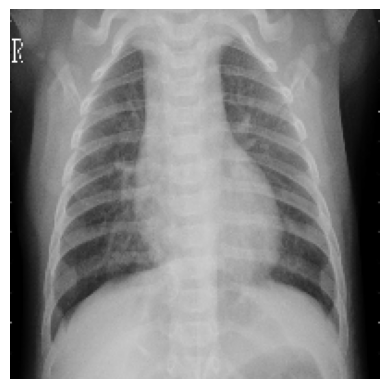

In [6]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [7]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [8]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [9]:
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=90, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=True)  

datagen.fit(X_train)

In [10]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

c:\Users\91897\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 200, 200, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 256)  │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 16)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,141 (3.05 MB)

 Trainable params: 799,791 (3.05 MB)

 Non-trainable params: 350 (1.37 KB)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=10)

c:\Users\91897\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - acc: 0.6851 - loss: 0.7131 - val_acc: 0.7407 - val_loss: 0.5635
Epoch 2/10
343/375 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - acc: 0.7306 - loss: 0.5419

In [23]:
model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 738ms/step - acc: 0.9203 - loss: 0.2162


[0.22764705121517181, 0.9121160507202148]

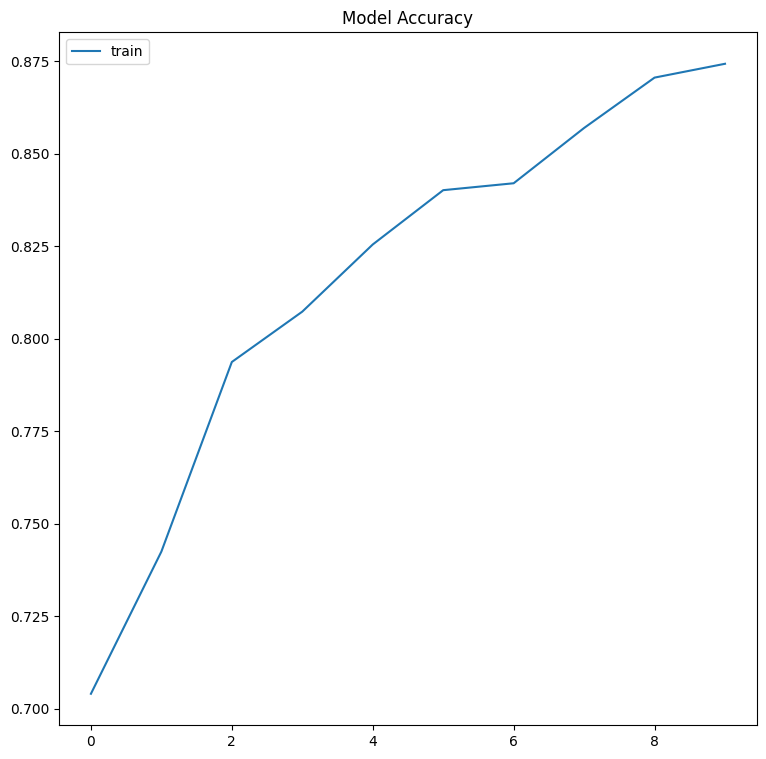

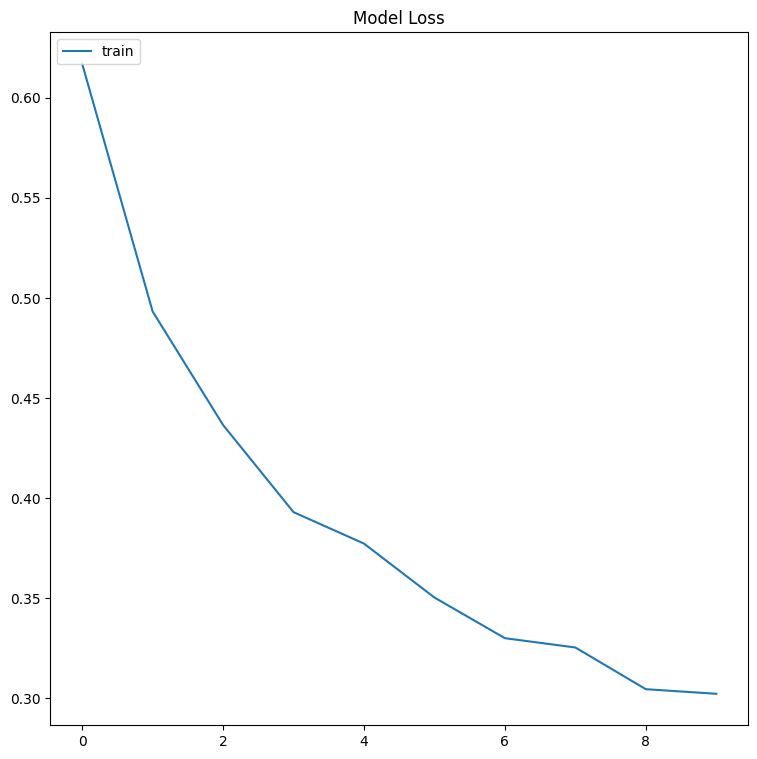

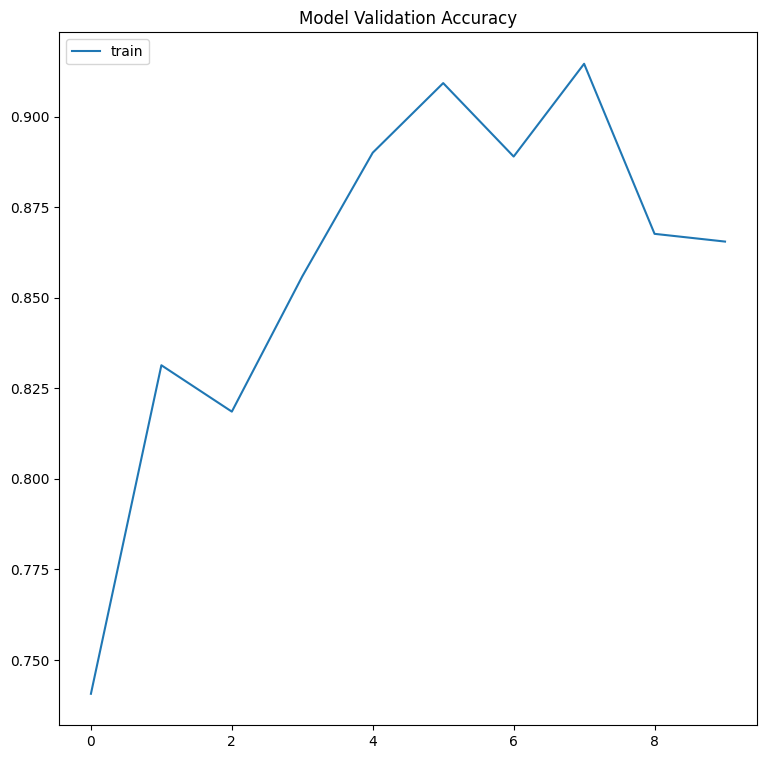

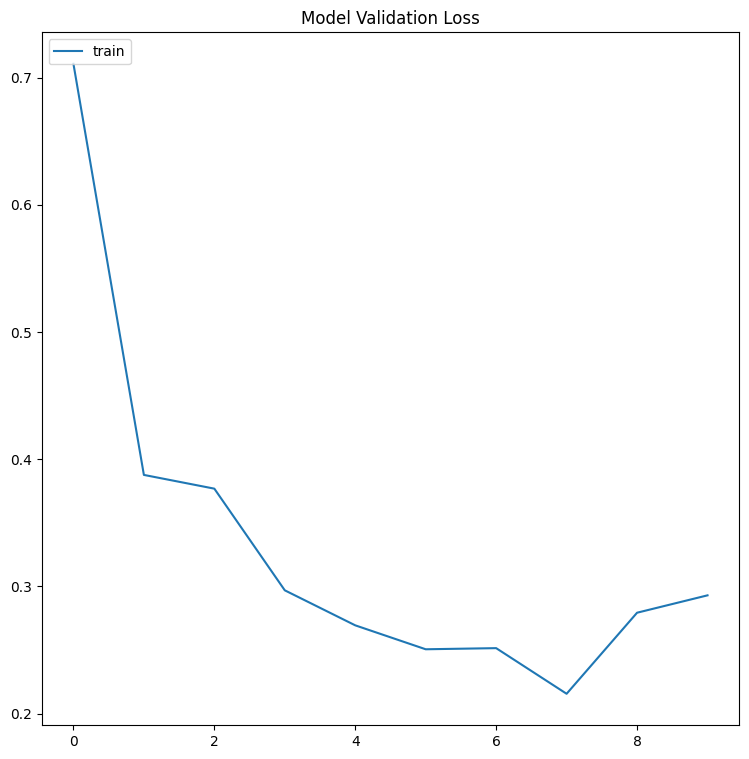

In [24]:
plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 697ms/step


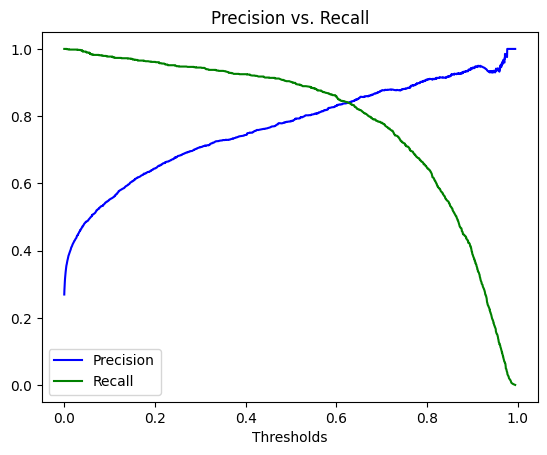

In [26]:
plt.plot(thresholds, precisions[:-1], 'b-')
plt.plot(thresholds, recalls[:-1], 'g-')
plt.title('Precision vs. Recall')
plt.xlabel('Thresholds')
plt.legend(['Precision', 'Recall'], loc='best')
plt.show()


In [27]:
predictions = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 656ms/step


In [28]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [29]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9155290102389079
Precision on testing set: 0.9240121580547113
Recall on testing set: 0.8042328042328042


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

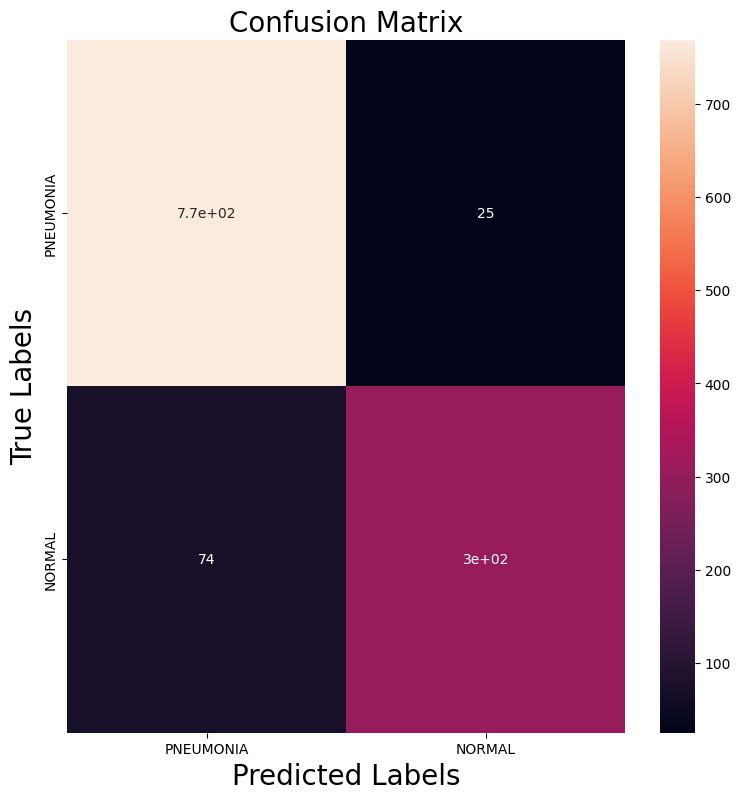

In [30]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt 
import seaborn as sns 
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [31]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(binary_predictions,y_test)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.91      0.97      0.94       794
           1       0.92      0.80      0.86       378

    accuracy                           0.92      1172
   macro avg       0.92      0.89      0.90      1172
weighted avg       0.92      0.92      0.91      1172



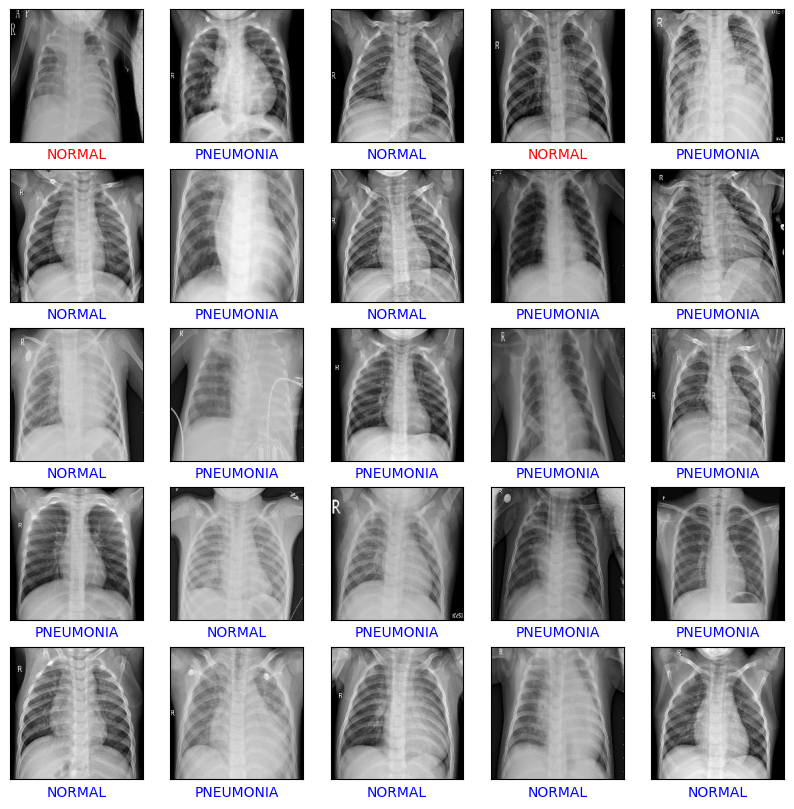

In [32]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [33]:
 model.save('pneumonia_detection_ai_version_3.h5')

In [34]:
import tensorflow.keras.layers as Layers
base_model = tf.keras.applications.MobileNetV2(input_shape=X_train.shape[1:],include_top=False,weights=None)
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))  
model.add(Dropout(0.1))
model.add(Layers.Dense(256, activation='relu'))
model.add(Layers.Dropout(0.1))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.01))  
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_200            │ (None, 7, 7, 1280)     │     2,257,408 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,914,177 (18.75 MB)

 Trainable params: 2,656,769 (10.13 MB)

 Non-trainable params: 2,257,408 (8.61 MB)

In [35]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[callbacks], validation_data=(X_val, y_val), epochs=5)

NameError: name 'model' is not defined

In [4]:
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

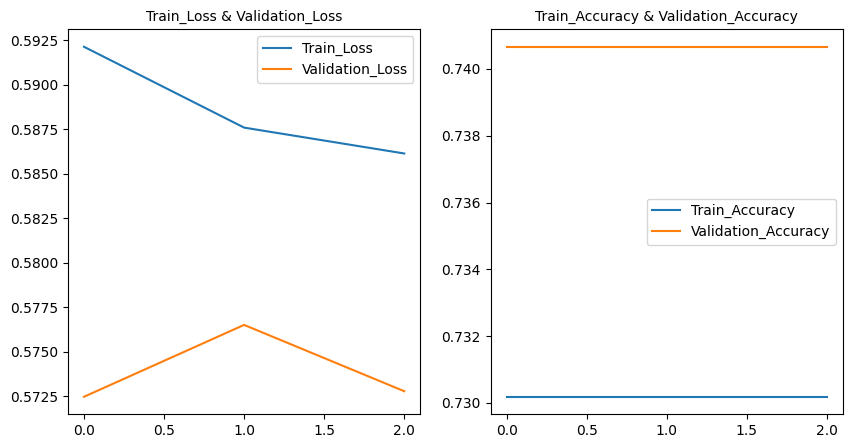

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'],label='Train_Loss')
plt.plot(history.epoch, history.history['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=10)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'],label='Train_Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=10)
plt.legend()

In [39]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 556ms/step


In [41]:
predictions = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 526ms/step


In [42]:
y_pred=np.where(predictions>=.5,1,0)

In [43]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(y_test,y_pred))

Accuracy on testing set: 0.7192832764505119


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

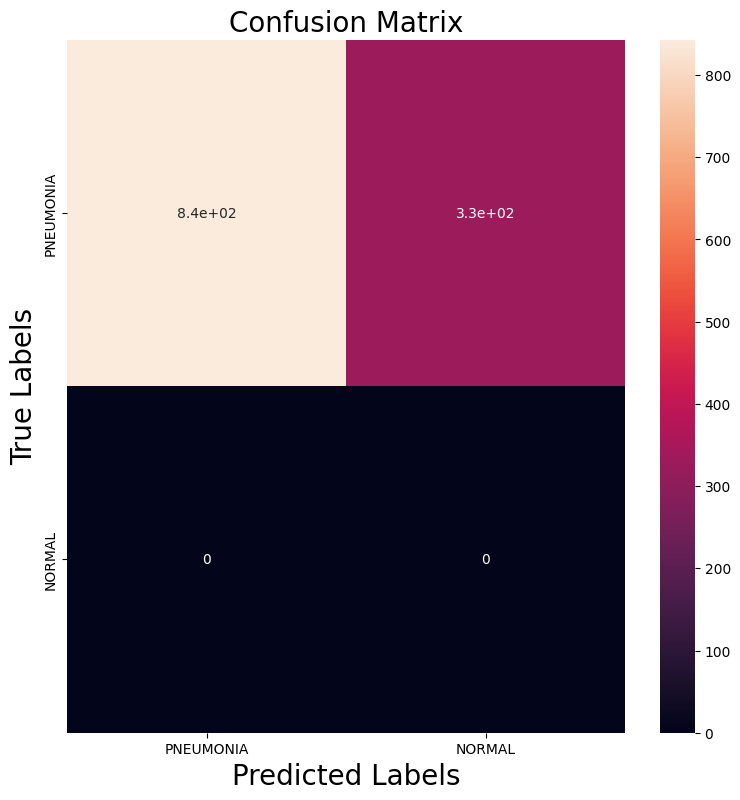

In [44]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt 
import seaborn as sns 
matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [45]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_pred,y_test)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.72      0.84      1172
           1       0.00      0.00      0.00         0

    accuracy                           0.72      1172
   macro avg       0.50      0.36      0.42      1172
weighted avg       1.00      0.72      0.84      1172



c:\Users\91897\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\91897\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\91897\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [46]:
base_model=tf.keras.applications.EfficientNetB0(weights = "imagenet", include_top = False, input_shape=(200, 200,3), pooling='max')
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.5))
model.add(Layers.Dense(256, activation='relu'))
model.add(Layers.Dropout(0.5))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.1))  
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,656,740 (21.58 MB)

 Trainable params: 1,607,169 (6.13 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [47]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[callbacks], validation_data=(X_val, y_val), epochs=5)

c:\Users\91897\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 383s 984ms/step - accuracy: 0.6224 - loss: 1.2796 - val_accuracy: 0.7407 - val_loss: 0.6711
Epoch 2/5
138/375 ━━━━━━━━━━━━━━━━━━━━ 2:43 692ms/step - accuracy: 0.7142 - loss: 0.6203

In [37]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 16s 420ms/step - loss: 0.5950 - accuracy: 0.7193


[0.5949643850326538, 0.7192832827568054]

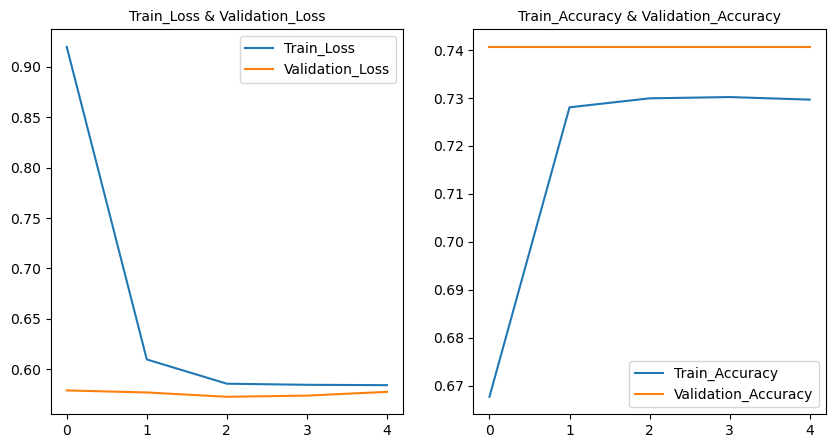

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'],label='Train_Loss')
plt.plot(history.epoch, history.history['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=10)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'],label='Train_Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=10)
plt.legend()

In [39]:
predictions = model.predict(X_test)

37/37 [==============================] - 18s 426ms/step


In [3]:
y_pred=np.where(predictions>=.5,1,0)

NameError: name 'np' is not defined

In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(y_test,y_pred))

Accuracy on testing set: 0.7192832764505119


In [2]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt 
import seaborn as sns 
matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

NameError: name 'y_pred' is not defined

In [1]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_pred,y_test)
print('Classification Report is : ', ClassificationReport )

NameError: name 'y_pred' is not defined